# Homework (Week 3) -- Biometrics (20 points)

In this homework we train Biometrics Verification model and use some features to increase quality:
1) Train ECAPA-TDNN (10 points)
2) Any contrastive loss (10 points)

Link to download dataset: https://disk.yandex.ru/d/lyhtieYbxQOYqw

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import tqdm.notebook as tqdm
import urllib

import dataset

from IPython.display import clear_output

%matplotlib inline

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/lyhtieYbxQOYqw'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O voxceleb.tar.gz "{download_url}"
!mkdir data
!tar -xf voxceleb.tar.gz -C data

--2025-11-25 22:53:39--  https://downloader.disk.yandex.ru/disk/b3eb29cb1b43d31835cfc9771e37c64a9418fabd9dda69ebbfdcf6d5e23890b0/69266bb3/gtj3WQiuHGabqHv6W0pVHGRnXFJAW27izLLMm2MbHXViekKTxmGtGgT-Cdced2Nyo5eSrwwUCF_GbUu7CV3RNA%3D%3D?uid=0&filename=voxceleb.tar.gz&disposition=attachment&hash=UbepA8Q9HDxeFKWCa8Y0tO7K9asCmTAjTZtG1dex6z7oEbCbmS7yu53hGphcr8rhq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=7150565898&hid=d5bd9cc88bda4eba5b285b6d33a11c38&media_type=compressed&tknv=v3
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s1144sas.storage.yandex.net/rdisk/b3eb29cb1b43d31835cfc9771e37c64a9418fabd9dda69ebbfdcf6d5e23890b0/69266bb3/gtj3WQiuHGabqHv6W0pVHGRnXFJAW27izLLMm2MbHXViekKTxmGtGgT-Cdced2Nyo5eSrwwUCF_GbUu7CV3RNA==?uid=0&

### Some model train example

In [4]:
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print("Using device:", DEVICE)

DATADIR = 'data'
FEATS = 80
LOADER_WORKERS = 8

Using device: cuda


In [5]:
transform = torchaudio.transforms.MFCC(n_mfcc=FEATS) # You can try some other transformations here
trainset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_train'), transform)
testset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_test'), transform)
test_targets = pd.read_csv(os.path.join(DATADIR, 'target.csv')).values.tolist()

/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### Models

In [5]:
class Model(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden: int, kernel: int = 7, sride: int = 2):
        super().__init__()
        self._emb = nn.Sequential(
            nn.Conv1d(input_shape, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.AdaptiveMaxPool1d(1),
        )
        self._final = nn.Sequential(
            nn.Linear(hidden, output_shape),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X) -> tuple[torch.Tensor, torch.Tensor]:
        emb = self._emb(X).squeeze(2)
        return self._final(emb), emb

### Metrics

Cosine similarity:
$CS(a, b) = \frac{<a, b>}{\|a\| \|b\|}$

In [6]:
def cosine_similarity(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

Here is O(N log N) algorithm for find best_eer:
1) Sort prediction by probability
2) Going through items and recalculating far and frr

In [7]:
def best_eer(data):
    full = sorted(data, key=lambda x: (x[0], -x[1]))
    pos = len([item for item in full if item[1] == 1])
    neg = len(full) - pos
    cur_pos = pos
    cur_neg = 0
    best_eer = 1
    for _, label in full:
        if label == 1:
            cur_pos -= 1
        else:
            cur_neg += 1
        cur_eer = max((pos - cur_pos) / pos, (neg - cur_neg) / neg)
        best_eer = min(best_eer, cur_eer)
    return best_eer

### Train

In [8]:
def train_stage(model, opt, batch_size: int = 256):
    loader = torch_data.DataLoader(
        trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    loss_sum = 0.0
    batches = 0
    for X, Y, _ in tqdm.tqdm(loader):
        logits, _ = model.forward(X.to(DEVICE))
        loss = F.nll_loss(logits, Y.to(DEVICE))
        loss_sum += loss.item()
        batches += 1
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss_sum / batches

In [9]:
def calc_eval_score(model: nn.Module, batch_size: int = 256):
    loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    items = {}
    target_scores = []
    with torch.no_grad():
        for X, _, pathes in tqdm.tqdm(loader):
            _, embds = model.forward(X.to(DEVICE))
            embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
            for embd, path in zip(embds, pathes):
                items[path] = embd
    for item1, item2, target in test_targets:
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
    return best_eer(target_scores)

In [10]:
def train(
    model: nn.Module,
    opt,
    batch_size: int = 256,
    epochs: int = 10,
    train_fun = train_stage,
    train_kwargs = {},
):
    train_losses = []
    eval_scores = []
    for epoch in range(epochs):
        model.train()
        train_losses.append(train_fun(model, opt, batch_size=batch_size))
        model.eval()
        eval_scores.append(calc_eval_score(model, batch_size=batch_size))
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train CE loss')
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='EER')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

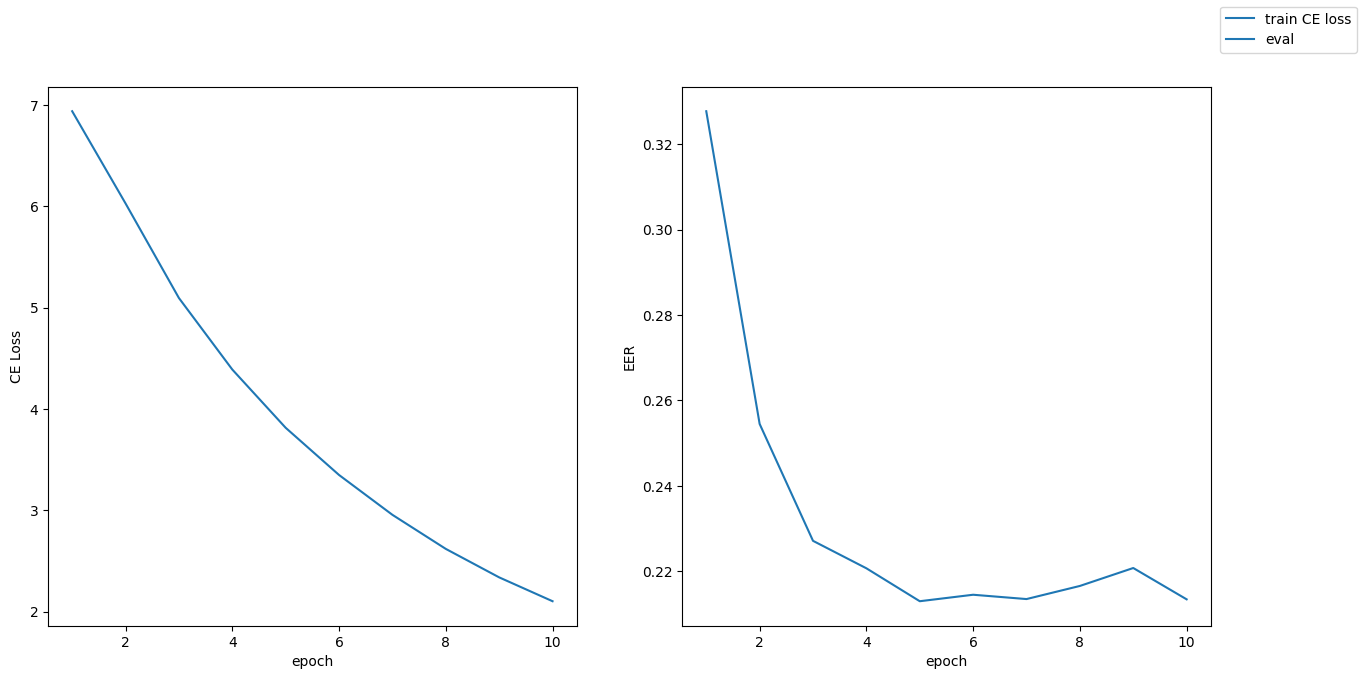

Epoch 10. Train loss 2.101770804063329. Eval score 0.21347392347518626


In [11]:
model = Model(FEATS, trainset.speakers(), 128).to(DEVICE)
opt = optim.Adam(model.parameters())
train(model, opt)

### ECAPA TDNN (10 points)

Paper: https://arxiv.org/pdf/2005.07143.pdf

Papers for ECAPA parts:
- SE-Blocks - https://arxiv.org/pdf/1709.01507.pdf
- Res2Net - https://arxiv.org/pdf/1904.01169.pdf
- Attentive Stats Pooling - https://arxiv.org/pdf/1803.10963.pdf
- AAM Softmax - https://arxiv.org/pdf/1906.07317.pdf

Also you can optionally add other settings for paper:
- SpecAug
- Weight decay for optimizer
- LR scheduler

In [11]:
class SEBlock(nn.Module):
    def __init__(self, input_shape: int, reduction: int = 1):
        super().__init__()
        # <YOUR CODE IS HERE>
        self.mlp = nn.Sequential(
            nn.Linear(input_shape, input_shape // reduction),
            nn.ReLU(),
            nn.Linear(input_shape // reduction, input_shape),
            nn.Sigmoid()
        )

    def __call__(self, X):
        # <YOUR CODE IS HERE>
        channels = torch.mean(X, dim=-1) # [b, c]
        weights = self.mlp(channels) # [b, c]
        return X * weights.unsqueeze(-1) # [b, c, t]

In [12]:
class Res2Net(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int, kernel_size: int = 3):
        super().__init__()
        assert hidden % scale == 0
        # <YOUR CODE IS HERE>
        self.scale = scale
        self.width = hidden // scale

        self.conv = nn.ModuleList([
            nn.Conv1d(self.width, self.width, kernel_size=kernel_size, padding='same', dilation=dilation)
            for _ in range(scale - 1)
        ])
        self.bn_relu = nn.Sequential(
            nn.BatchNorm1d(hidden),
            nn.ReLU()
        )

    def __call__(self, X):
        # <YOUR CODE IS HERE>
        splits = torch.split(X, self.width, dim=1)
        y = [splits[0]]
        for i in range(1, self.scale):
            if i == 1:
                sp = splits[i]
            else:
                sp = splits[i] + y[i - 1]
            sp = self.conv[i - 1](sp)
            y.append(sp) 
        out = torch.cat(y, dim=1)
        return self.bn_relu(out)

In [13]:
class EcapaBlock(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int):
        super().__init__()
        # <YOUR CODE IS HERE>
        self.conv_in = nn.Sequential(nn.Conv1d(hidden, hidden, 1), nn.BatchNorm1d(hidden), nn.ReLU())
        self.res2net = Res2Net(hidden, dilation, scale)
        self.conv_out = nn.Sequential(nn.Conv1d(hidden, hidden, 1), nn.BatchNorm1d(hidden), nn.ReLU())
        self.se_block = SEBlock(hidden)

    def __call__(self, X):
        # <YOUR CODE IS HERE>
        out = self.conv_in(X)
        out = self.res2net(out)
        out = self.conv_out(out)
        out = self.se_block(out)
        return X + out

In [ ]:
class AttentiveStatsPooling(nn.Module):
    def __init__(self, input_shape: int, hidden: int):
        super().__init__()
        # <YOUR CODE IS HERE>
        self.attn = nn.Sequential(
            nn.Conv1d(input_shape * 3, hidden, 1),
            nn.ReLU(),
            nn.Conv1d(hidden, input_shape, 1)
        )

    def forward(self, X):
        # X shape = [time, feats]
        # calc mean and std for X over time dimension
        # concatenate mean and std to X over feats dimension to make shape [time, feats * 3]
        # attention
        # weighted mean and std with weights from attention for original X
        
        # <YOUR CODE IS HERE> sps X shape = [feats, time]
        X_mean_expanded = X.mean(dim=-1)[..., None].expand_as(X)
        X_std_expanded = X.std(dim=-1)[..., None].expand_as(X)
        X_expanded = torch.cat([X, X_mean_expanded, X_std_expanded], dim=1)
        weight = F.softmax(self.attn(X_expanded), dim=-1)
        mean = torch.sum(weight * X, dim=-1)
        std = torch.sqrt(torch.sum(weight * (X**2), dim=-1) - mean ** 2 + 1e-5)
        return torch.cat([mean, std], dim=-1)

In [15]:
import math
class AAMSoftmax(nn.Module):
    def __init__(self, input_shape, n_class, margin, scale):
        super().__init__()
        # <YOUR CODE IS HERE>
        self.m = margin
        self.s = scale
        self.w = nn.Parameter(torch.empty((n_class, input_shape)))
        nn.init.kaiming_uniform_(self.w, a=math.sqrt(5))

    def forward(self, X):
        # calc cosine similarity between X and weights
        # theta = angle from cosine similarity
        # return matrix S, where S_ij = 
        #     \log \frac{
        #         \exp{scale \cos{theta_ij + margin}}
        #     }{
        #         \exp{scale \cos{theta_ij + margin}} + \sum_{k != j} \exp{scale \cos{theta_ik}}
        #     }
        # <YOUR CODE IS HERE>
        
        thetas = torch.acos(torch.mm(F.normalize(X, dim=-1), F.normalize(self.w, dim=-1).transpose(0, 1)).clamp(-1, 1))
        cos_exp = torch.exp(self.s * torch.cos(thetas))
        cos_exp_m = torch.exp(self.s * torch.cos(thetas + self.m))
        sum_cos = torch.sum(cos_exp, dim=-1)[..., None].expand_as(cos_exp)
        return torch.log(cos_exp_m / (sum_cos - cos_exp + cos_exp_m))

In [16]:
class EcapaTDNN(nn.Module):
    def __init__(self, input_shape: int, n_classes: int, output_shape: int):
        super().__init__()
        # <YOUR CODE IS HERE>
        self.conv_bn_relu = nn.Sequential(
            nn.Conv1d(input_shape, output_shape, kernel_size=5, padding='same', dilation=1),
            nn.BatchNorm1d(output_shape),
            nn.ReLU()
        )
        self.ecapa_block1 = EcapaBlock(output_shape, dilation=2, scale=8)
        self.ecapa_block2 = EcapaBlock(output_shape, dilation=3, scale=8)
        self.ecapa_block3 = EcapaBlock(output_shape, dilation=4, scale=8)
        self.conv_relu = nn.Sequential(
            nn.Conv1d(output_shape*3, 1536, kernel_size=1),
            nn.ReLU()
        )
        self.asp = AttentiveStatsPooling(1536, 512)
        self.fc = nn.Linear(3072, 192)
        self.bn = nn.BatchNorm1d(192)
        self.aam = AAMSoftmax(input_shape=192, n_class=n_classes, margin=0.2, scale=10)

    def forward(self, X):
        # <YOUR CODE IS HERE>
        X = self.ecapa_block1(self.conv_bn_relu(X))
        out1 = self.ecapa_block2(X)
        out2 = self.ecapa_block3(out1)
        X = torch.cat([X, out1, out2], dim=1)
        X = self.conv_relu(X)
        X = self.asp(X)
        X = self.bn(self.fc(X))
        return self.aam(X), X

Train ECAPA model, at this point you can archive stable score (for several consecutive epochs) near 0.08 EER.

You can train ECAPA with hidden size 256 to increase speed

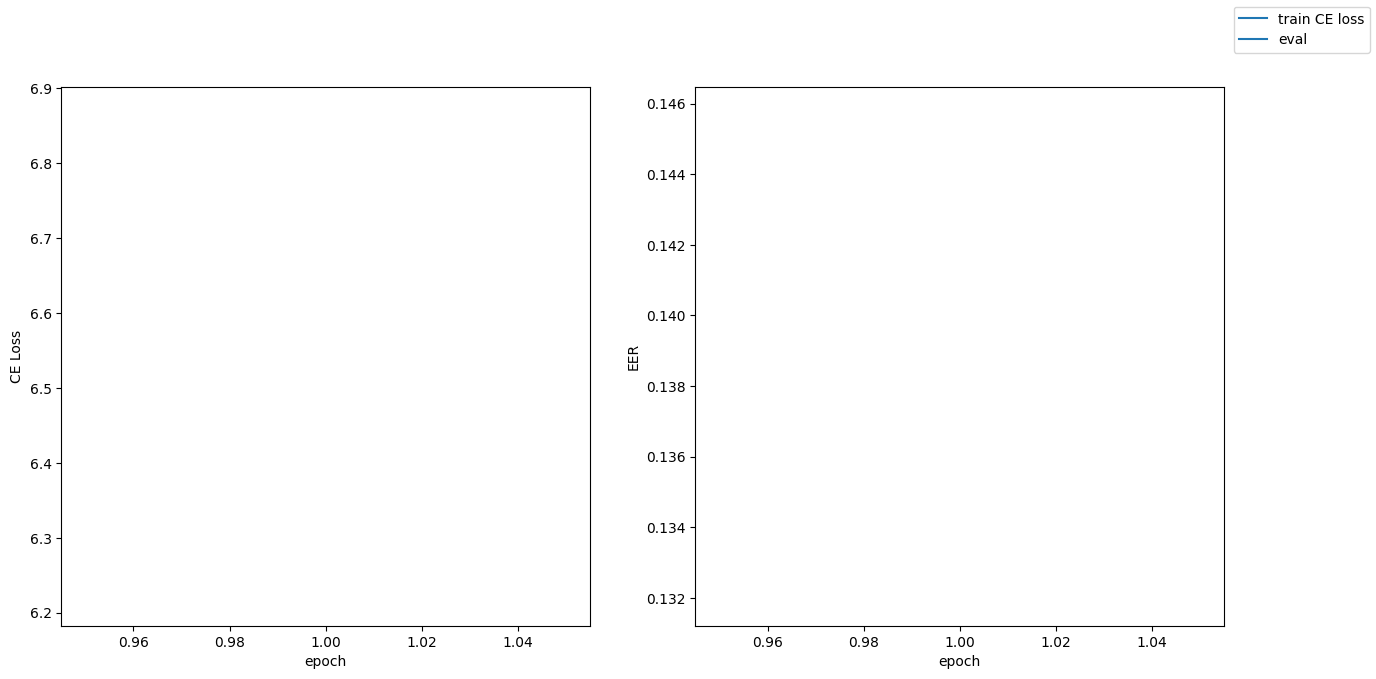

Epoch 1. Train loss 6.542276231297907. Eval score 0.13884328829397652


In [ ]:
model = EcapaTDNN(FEATS, trainset.speakers(), 128).to(DEVICE)
opt = optim.Adam(model.parameters())
train(model, opt, batch_size=128, epochs=1)

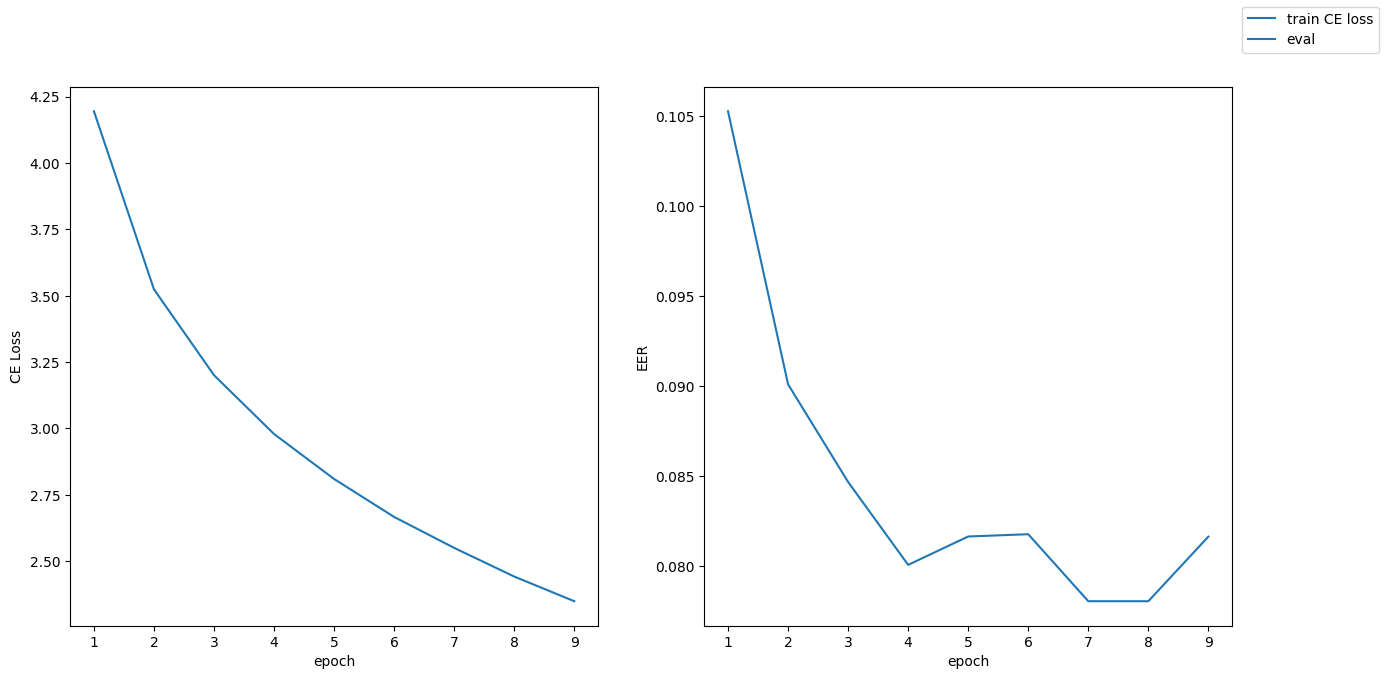

Epoch 9. Train loss 2.34963839009123. Eval score 0.08163265306122448


In [20]:
train(model, opt, batch_size=128, epochs=9)

In [21]:
# Save model to preserve results before uptraining experiments
torch.save(model, 'model.pt')

### Contrastive losses (10 points)

You can use anyone constrative loss.
Good article with contrastive losses https://lilianweng.github.io/posts/2021-05-31-contrastive/

Base losses:
- contrastive
- triplet -- it gives a better quality usually
- lifted structured loss -- better batch data utilization

The main problem with contrastive loss is the positive pairs sampler.
This is because a large number of classes provided only once per batch
in case of large number of classes in the dataset.

In [ ]:
class PositivePairsSampler(torch.utils.data.Sampler):
    def __init__(self, speakers: list[int], batch_size: int):
        pass
        # <YOUR CODE IS HERE>

    def __len__(self):
        pass
        # <YOUR CODE IS HERE>

    def __iter__(self):
        # yield __len__ batches as list of indexes of samples from dataset
        # <YOUR CODE IS HERE>
        for _ in range(len(self)):
            indexes = []
            # <YOUR CODE IS HERE>
            yield indexes

In [ ]:
def contrastive_train_stage(model, opt, batch_size: int = 256):
    # You can use any contrastive loss here to improve training
    # You can combine contrastive loss with the NLL loss after AAM softmax to improve stability
    loader = torch_data.DataLoader(
        trainset,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
        batch_sampler=PositivePairsSampler(trainset._speakers, batch_size)
    )
    # <YOUR CODE IS HERE>

Train model with contrastive loss here. At this point you can archive EER near 0.06-0.07 (it should be at least on 0.005 to 0.01 better than before)

In [ ]:
model = torch.load('model.pt').to(DEVICE)
opt = optim.Adam(model.parameters())
train(model, opt, batch_size=128, train_fun=contrastive_train_stage)